In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copairs import map

## Download data

Download a single plate of profiles from the dataset "cpg0004" (aka LINCS), which contains Cell Painting images of 1,327 small-molecule perturbations of A549 human cells. The wells on each plate were perturbed with 56 different compounds in six different doses.

> Way, G. P. et al. Morphology and gene expression profiling provide complementary information for mapping cell state. Cell Syst 13, 911–923.e9 (2022).

In [2]:
commit = "da8ae6a3bc103346095d61b4ee02f08fc85a5d98"
plate = "SQ00014812"
url = f"https://media.githubusercontent.com/media/broadinstitute/lincs-cell-painting/{commit}/profiles/2016_04_01_a549_48hr_batch1/{plate}/{plate}_normalized_feature_select.csv.gz"

df = pd.read_csv(url)
df = df.loc[:, df.nunique() > 1] # remove constant columns
df

,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,Metadata_broad_sample_type,Metadata_pert_type,Metadata_broad_id,Metadata_InChIKey14,...,Nuclei_Texture_InverseDifferenceMoment_AGP_5_0,Nuclei_Texture_InverseDifferenceMoment_DNA_20_0,Nuclei_Texture_InverseDifferenceMoment_ER_5_0,Nuclei_Texture_InverseDifferenceMoment_Mito_10_0,Nuclei_Texture_InverseDifferenceMoment_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_Variance_RNA_10_0
0,DMSO,0.000000,0.000000,NaN,NaN,A01,control,control,NaN,NaN,...,-1.3544,-1.07770,2.26020,-0.377010,-0.065840,2.12360,2.8740,2.87500,2.3047,-0.92358
1,DMSO,0.000000,0.000000,NaN,NaN,A02,control,control,NaN,NaN,...,-2.3840,-0.73440,1.12090,-0.182500,-0.061450,0.66985,2.3919,2.35230,1.8672,-0.11820
2,DMSO,0.000000,0.000000,NaN,NaN,A03,control,control,NaN,NaN,...,-1.9493,-0.36148,0.44050,0.326660,0.547200,0.25015,1.2271,0.77847,1.0651,-0.44810
3,DMSO,0.000000,0.000000,NaN,NaN,A04,control,control,NaN,NaN,...,-2.2909,-0.46380,0.96434,1.132200,0.753500,0.31403,1.4384,1.48110,1.2943,-0.83810
4,DMSO,0.000000,0.000000,NaN,NaN,A05,control,control,NaN,NaN,...,-1.8955,-1.05350,1.64840,0.057781,0.070229,1.60990,1.1296,0.90213,1.1016,0.53225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,BRD-K82746043-001-15-1,3.248700,3.333300,BRD-K82746043,BRD-K82746043-001-15-1,P20,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,...,-6.1522,1.81410,1.54220,-1.874700,-1.133900,1.57540,-3.0962,-3.25160,-2.7683,1.40170
380,BRD-K82746043-001-15-1,1.082900,1.111100,BRD-K82746043,BRD-K82746043-001-15-1,P21,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,...,-5.1586,1.50580,1.68420,-1.126400,-1.066600,1.24740,-1.5305,-1.79020,-1.2474,1.17600
381,BRD-K82746043-001-15-1,0.360970,0.370370,BRD-K82746043,BRD-K82746043-001-15-1,P22,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,...,-5.9475,1.42100,1.51020,-1.103600,-1.666500,1.19840,-2.6086,-2.97620,-2.0026,0.91557
382,BRD-K82746043-001-15-1,0.120320,0.123460,BRD-K82746043,BRD-K82746043-001-15-1,P23,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,...,-8.4408,2.99620,2.55230,-2.275200,-1.783500,2.49200,-4.3964,-4.19030,-3.8360,1.02240


## Calculate mAP for assessing phenotypic activity of compounds

Phenotypic activity of a perturbation reflects the average extent to which its replicate profiles are more similar to each other compared to control profiles (see Figure 1E in the [pre-print](https://doi.org/10.1101/2024.04.01.587631)).

Here, we treat different doses of each compound as replicates and assess how well we can retrieve them by similarity against the group of negative controls (DMSO).

To ensure correct grouping of profiles, we will add a dummy column that is equal to row index for all compound replicates and to -1 for all DMSO replicates. 

In [3]:
df["Metadata_treatment_index"] = df.index
df.loc[df["Metadata_broad_sample"] == "DMSO", "Metadata_treatment_index"] = -1
df

,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,Metadata_broad_sample_type,Metadata_pert_type,Metadata_broad_id,Metadata_InChIKey14,...,Nuclei_Texture_InverseDifferenceMoment_DNA_20_0,Nuclei_Texture_InverseDifferenceMoment_ER_5_0,Nuclei_Texture_InverseDifferenceMoment_Mito_10_0,Nuclei_Texture_InverseDifferenceMoment_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_Variance_RNA_10_0,Metadata_treatment_index
0,DMSO,0.000000,0.000000,NaN,NaN,A01,control,control,NaN,NaN,...,-1.07770,2.26020,-0.377010,-0.065840,2.12360,2.8740,2.87500,2.3047,-0.92358,-1
1,DMSO,0.000000,0.000000,NaN,NaN,A02,control,control,NaN,NaN,...,-0.73440,1.12090,-0.182500,-0.061450,0.66985,2.3919,2.35230,1.8672,-0.11820,-1
2,DMSO,0.000000,0.000000,NaN,NaN,A03,control,control,NaN,NaN,...,-0.36148,0.44050,0.326660,0.547200,0.25015,1.2271,0.77847,1.0651,-0.44810,-1
3,DMSO,0.000000,0.000000,NaN,NaN,A04,control,control,NaN,NaN,...,-0.46380,0.96434,1.132200,0.753500,0.31403,1.4384,1.48110,1.2943,-0.83810,-1
4,DMSO,0.000000,0.000000,NaN,NaN,A05,control,control,NaN,NaN,...,-1.05350,1.64840,0.057781,0.070229,1.60990,1.1296,0.90213,1.1016,0.53225,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,BRD-K82746043-001-15-1,3.248700,3.333300,BRD-K82746043,BRD-K82746043-001-15-1,P20,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,...,1.81410,1.54220,-1.874700,-1.133900,1.57540,-3.0962,-3.25160,-2.7683,1.40170,379
380,BRD-K82746043-001-15-1,1.082900,1.111100,BRD-K82746043,BRD-K82746043-001-15-1,P21,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,...,1.50580,1.68420,-1.126400,-1.066600,1.24740,-1.5305,-1.79020,-1.2474,1.17600,380
381,BRD-K82746043-001-15-1,0.360970,0.370370,BRD-K82746043,BRD-K82746043-001-15-1,P22,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,...,1.42100,1.51020,-1.103600,-1.666500,1.19840,-2.6086,-2.97620,-2.0026,0.91557,381
382,BRD-K82746043-001-15-1,0.120320,0.123460,BRD-K82746043,BRD-K82746043-001-15-1,P23,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,...,2.99620,2.55230,-2.275200,-1.783500,2.49200,-4.3964,-4.19030,-3.8360,1.02240,382


Next, we define the rules by which profiles are grouped based on metadata:

* Two profiles are a positive pair if they belong to the same group (i.e., they are replicates of the same compound). Therefore, they should share the same value in the metadata column that identifies the specific compound. We add this column to a list names `pos_sameby`.

* No metadata columns are additionally needed to tell apart replicates of the same compound here (although in theory, one could request them to be from different plate rows or columns, for instance). So we keep `pos_diffby` empty.

* Two profiles are a negative pair when one of them belongs to a group of compound replicates and another to a group of controls. That means they should be different both in the metadata column that identifies the specific compound and the treatment index columns that we created. The latter is needed to ensure that replicates of compounds are retrieved against only negative controls at this stage (and not against replicates of other compounds). We list these columns in `neg_diffby`.

* No metadata columns are additionally needed to define negative pairs. So we keep `neg_sameby` empty.

In [4]:
pos_sameby = ["Metadata_broad_sample"]
pos_diffby = []

neg_sameby = []
neg_diffby = ["Metadata_broad_sample", "Metadata_treatment_index"]

Now we can use `average_precision` function to calculate the average precision score for each replicate of each compound.

In [5]:
metadata = df.filter(regex="^Metadata")
profiles = df.filter(regex="^(?!Metadata)").values

ap_scores = map.average_precision(metadata, profiles, pos_sameby, pos_diffby, neg_sameby, neg_diffby)
ap_scores = ap_scores.query("Metadata_broad_sample != 'DMSO'") # remove DMSO
ap_scores

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,Metadata_broad_sample_type,Metadata_pert_type,Metadata_broad_id,Metadata_InChIKey14,Metadata_moa,Metadata_target,Metadata_broad_date,Metadata_Well,Metadata_treatment_index,n_pos_pairs,n_total_pairs,average_precision
6,BRD-K74363950-004-01-0,5.655600,10.000000,BRD-K74363950,BRD-K74363950-004-01-0,A07,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5,broad_id_20170327,A07,6,5,383,0.050922
7,BRD-K74363950-004-01-0,1.885200,3.333300,BRD-K74363950,BRD-K74363950-004-01-0,A08,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5,broad_id_20170327,A08,7,5,383,0.308904
8,BRD-K74363950-004-01-0,0.628400,1.111100,BRD-K74363950,BRD-K74363950-004-01-0,A09,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5,broad_id_20170327,A09,8,5,383,0.412513
9,BRD-K74363950-004-01-0,0.209470,0.370370,BRD-K74363950,BRD-K74363950-004-01-0,A10,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5,broad_id_20170327,A10,9,5,383,0.377730
10,BRD-K74363950-004-01-0,0.069823,0.123460,BRD-K74363950,BRD-K74363950-004-01-0,A11,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5,broad_id_20170327,A11,10,5,383,0.715591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,BRD-K82746043-001-15-1,3.248700,3.333300,BRD-K82746043,BRD-K82746043-001-15-1,P20,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,BCL inhibitor,BCL2|BCL2L1|BCL2L2,broad_id_20170327,P20,379,5,383,0.726786
380,BRD-K82746043-001-15-1,1.082900,1.111100,BRD-K82746043,BRD-K82746043-001-15-1,P21,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,BCL inhibitor,BCL2|BCL2L1|BCL2L2,broad_id_20170327,P21,380,5,383,0.658824
381,BRD-K82746043-001-15-1,0.360970,0.370370,BRD-K82746043,BRD-K82746043-001-15-1,P22,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,BCL inhibitor,BCL2|BCL2L1|BCL2L2,broad_id_20170327,P22,381,5,383,0.517619
382,BRD-K82746043-001-15-1,0.120320,0.123460,BRD-K82746043,BRD-K82746043-001-15-1,P23,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,BCL inhibitor,BCL2|BCL2L1|BCL2L2,broad_id_20170327,P23,382,5,383,0.543290


At the next step, we average the AP scores, calculate p-value using permutation testing, and perform FDR correction to compare across compounds.

In [6]:
map_scores = map.mean_average_precision(ap_scores, pos_sameby, null_size=10000, threshold=0.05, seed=0)
map_scores["-log10_p_value"] = -map_scores["corrected_p_value"].apply(np.log10)
map_scores

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

,Metadata_broad_sample,mean_average_precision,p_value,corrected_p_value,below_p,below_corrected_p,-log10_p_value
0,BRD-A69275535-001-01-5,0.203576,0.012899,0.016390,True,True,1.785430
1,BRD-A69636825-003-04-7,0.269093,0.000800,0.001365,True,True,2.865004
2,BRD-A69815203-001-07-6,0.862226,0.000100,0.000276,True,True,3.558835
3,BRD-A70858459-001-01-7,0.351816,0.000200,0.000400,True,True,3.397983
4,BRD-A72309220-001-04-1,0.263986,0.000900,0.001491,True,True,2.826441
5,BRD-A72390365-001-15-2,0.554667,0.000100,0.000276,True,True,3.558835
6,BRD-A73368467-003-17-6,0.788666,0.000100,0.000276,True,True,3.558835
7,BRD-A74980173-001-11-9,0.500600,0.000100,0.000276,True,True,3.558835
8,BRD-A81233518-004-16-1,0.140208,0.015598,0.018700,True,True,1.728154
9,BRD-A82035391-001-02-7,0.052362,0.077692,0.078692,False,False,1.104069


Finally, we can plot the results:

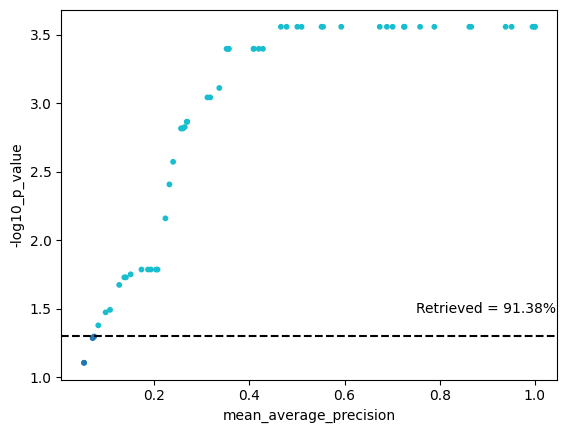

In [22]:
plt.scatter(data=map_scores, x="mean_average_precision", y="-log10_p_value", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mean_average_precision")
plt.ylabel("-log10_p_value")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.75, 1.5, f"Retrieved = {100*map_scores.below_corrected_p.mean():.2f}%", va="center", ha="left")
plt.show()